# Windy City TD 
SARSA on-policy control

This notebook works the the problem of on-policy TD control for estimating Q ≈ q<sub>*</sub> 
    
We apply this towards the windy city grid world problem. The objective is to get from the start square to reach the terminal state. The grid world will have columns that contain a 'wind' effect where transitions into that state will push them 'up' or 'north' a specified amount of units affecting the traversal of the 'map'.
    
Objects to create:
- environment to simulate the 'windy city'
- entity to simulate the traversal thru the paths
    
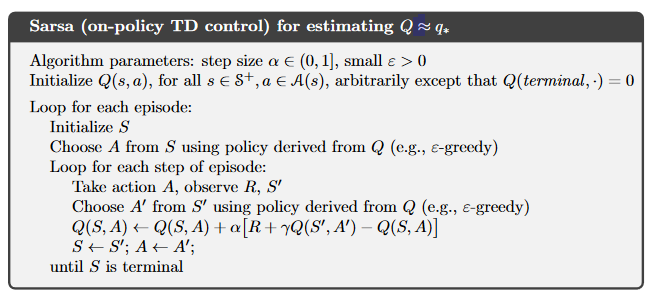

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.table import Table
import numpy as np

In [2]:
#define environment object
class environment():
    def __init__(self, dims = [7,10], start = [3,0] , terminal = [3,7], reward = -1, windy_cols = [0,0,0,1,1,1,2,2,1,0]):
        """
        this class initializes the environment
        
        inputs
        dims - a scalar to define a dxd grid environment
        terminals - a list of lists of ordered pairs representing the location in the grid of the terminal states
        reward -  the reward value for moving one space (unless in a terminal state)
        
        self defined variables
        actions - determines actions that can be taken in the environment where 0 = left, 1 = up, 2 = right, 3 = down
        
        returns
        None
        
        cheating here as i did not do checks on things for integrity...
        """
        self.dims = dims
        self.start = start
        self.terminal = terminal
        self.reward = reward
        self.windy_cols = windy_cols
        self.actions = [np.array([0, -1]),
                       np.array([-1, 0]),
                       np.array([0, 1]),
                       np.array([1, 0])]
            
    def is_terminal(self,i,j):
        """
        This function checks if coordinates are for a terminal state
        
        inputs
        i = y coord (row)
        j = x coord (col)
        
        returns
        boolean on terminal status
        """
        #print("episode end")
        return [i,j] == self.terminal
        
        
    def next_state(self,i,j,a):
        """
        this function determines the next state and the reward received
        This function also checks if current state is terminal, or next state is terminal
        This function will also bounce back to the original coordinates if it is an edge/border square in the grid
        
        inputs
        i = y coord (row)
        j = x coord (col)
        a = action taken where 0 = left, 1 = up, 2 = right, 3 = down
        
        returns
        i_next, j_next representing next state coordinates
        reward received for moving
        """
        # check if current state is terminal, if so return current state and reward = 0
        #i = row, j = col
        if self.is_terminal(i,j):
            return i, j, 0
        
        # get next state
        next = [i,j] + self.actions[a]     
        
             
        #apply wind
        windy = 0
        if self.windy_cols[j] != 0:
            windy = 1
            next[0] = next[0] - self.windy_cols[next[1]]         
        
        #check if next state is outside boundries of the grid
        if windy == 0:
            if next[0] < 0 or next[1] <0:
                return i, j, self.reward
            elif next[0] > (self.dims[0]-1) or next[1] > (self.dims[1]-1):
                return i, j, self.reward
            else:
                return next[0], next[1], self.reward  
        else:
            if next[0] < 0:
                return 0, next[1], self.reward
            else:
                return next[0], next[1], self.reward 


In [3]:
class entity():
    def __init__(self, state_action_values, environment, algo_param_alpha = 0.25, gamma = 0.5, epsilon = 0.05, start = [3,0]):
        """
        This class initializes the entity which will 
        walk thru the grid world and collect data
        this follows a puerly greedy policy atm
        
        inputs
        rand_policy = policy ot follow if not initialized
        state_action_values - calculated state-action values for all states except the terminal state
        algo_param_alpha - step size to be used
        
        """
        
        self.state_action_values = state_action_values
        self.algo_param_alpha = algo_param_alpha
        self.gamma = gamma
        self.environment = environment
        self.start_location = start
        self.current_location = start
        self.epsilon = epsilon

                
    def pick_action(self, state_action_values):
        #need to fix this asap
        
        #simple pick action based in random policy to go any direction with equal probability
        greedy_action = np.argmax(state_action_values)
        #print(greedy_action)
        
        action = greedy_action
        
        if self.epsilon == 0:
            return action
        
        if np.random.binomial(1, self.epsilon, 1):
            temp_list = [0,1,2,3]
            #print(temp_list)
            temp_list.pop(greedy_action)
            #print(temp_list)
            action = np.random.choice(temp_list)
            #print(action)
        
        return action
    
    def take_action(self, action):
        next_i, next_j, reward = self.environment.next_state(self.current_location[0], self.current_location[1], action)
        return next_i, next_j, reward
    
    def restart_walk(self):
        self.current_location = self.start_location
    
    def take_a_walk(self):
        
        self.restart_walk()
        
        terminal = False
        
        #choose first action according to e-greedy
        i, j = self.current_location[0], self.current_location[1]
        state_action_values = self.state_action_values[(i,j)]
        action = self.pick_action(state_action_values)
        next_i, next_j, reward = self.take_action(action)
        
        while not terminal:

            state_action_values = self.state_action_values[(next_i, next_j)]
            next_action = self.pick_action(state_action_values)
            next_action_value = state_action_values[next_action]
            
            #update last state value
            self.state_action_values[(i,j)][action] = \
            (self.state_action_values[(i,j)][action] + \
            (self.algo_param_alpha * \
            (reward + \
            (self.gamma * next_action_value) - \
            self.state_action_values[(i,j)][action])))
             
            #update location
            self.current_location = [next_i, next_j] 
            i, j = next_i, next_j
            
            #update to iterate 
            action = next_action
            next_i, next_j, reward = self.take_action(action)
            
            
            if reward == 0:
                terminal = True
                
    def policy_walk(self):
        self.restart_walk()
        
        terminal = False
        
        action_dict = {0 : "left", 1 : "up", 2 : "right", 3 : "down"}
        
        number_of_steps = 0
        
        orig_epsilon = self.epsilon
        
        self.epsilon = 0
        
        while not terminal:
            print("current state is:", self.current_location)
            print("current step is:", number_of_steps)
            state_action_values = self.state_action_values[(self.current_location[0],self.current_location[1])]
            
            action = self.pick_action(state_action_values)
            print("next action is:", action_dict[action])
            
            next_i, next_j, reward = self.take_action(action)
            
            #update location
            self.current_location = [next_i, next_j] 
            
            number_of_steps = number_of_steps + 1
            
            if number_of_steps > 100:
                print("walk failure")
                reward = 0
            
            if reward == 0:
                print("you have reached the terminal state in ", number_of_steps, " steps!")
                self.epsilon = orig_epsilon                      
                terminal = True          
                
    def give_state_action_values(self):
        return self.state_action_values
    

In [4]:
#step size
algo_param_alpha = 0.25

In [5]:
#dimensions
dims = [7,10]

In [6]:
#arbitrary state_action_values
#using a dict because look up is much easier then
state_action_values = {(None,None,None):0}

for i in range(dims[0]):
    for j in range(dims[1]):
        state_action_values[(i,j)] = [0,0,0,0]
        
state_action_values.pop((None,None,None))
            
#state_action_values

0

In [7]:
environment1 = environment()
entity1 = entity(state_action_values, environment1)

In [8]:
number_of_episodes = 1000

for episode in range(number_of_episodes):
    #if episode%100 == 0:
        #print("episode #:", episode)
    entity1.take_a_walk()
    
state_action_values = entity1.give_state_action_values()

policy = np.zeros((dims[0],dims[1],4))

for key in state_action_values:
    i =  key[0]
    j = key[1]
    policy[i,j] = state_action_values[key]
    


In [9]:
state_action_values

{(0, 0): [-1.9999574666190392,
  -1.9999512177071739,
  -1.9999496150361487,
  -1.9999584317412167],
 (0, 1): [-1.9999357958581054,
  -1.9999338939306444,
  -1.9999302251917028,
  -1.9999380022741216],
 (0, 2): [-1.999892398814211,
  -1.9999016318121507,
  -1.9998951704683483,
  -1.999904758176412],
 (0, 3): [-1.9998262408689385,
  -1.9998398808225684,
  -1.999816729978373,
  -1.9998279030322008],
 (0, 4): [-1.9997538546082498,
  -1.9996810939264613,
  -1.9996486866257155,
  -1.9997375035727283],
 (0, 5): [-1.9995326398124673,
  -1.999498786877421,
  -1.9992595906594721,
  -1.9994479937846954],
 (0, 6): [-1.9995977623189192,
  -1.9992653121770696,
  -1.9984149863530452,
  -1.9992760890421657],
 (0, 7): [-1.999369873502635,
  -1.9986576717662903,
  -1.9967817381972506,
  -1.9984313327255883],
 (0, 8): [-1.998776719141107,
  -1.9966857241822178,
  -1.9932040175510053,
  -1.9967641837648977],
 (0, 9): [-1.9973331829339735,
  -1.9937956440833888,
  -1.9942479987655826,
  -1.985487327135280

In [10]:
#optimal steps for this problem is 15, book notes 17 is the average on their solution
#this method sets epsilon to 0 and uses the q values to do a pure exploitation.
print("doing policy walk")
entity1.policy_walk()

doing policy walk
current state is: [3, 0]
current step is: 0
next action is: right
current state is: [3, 1]
current step is: 1
next action is: right
current state is: [3, 2]
current step is: 2
next action is: right
current state is: [3, 3]
current step is: 3
next action is: right
current state is: [2, 4]
current step is: 4
next action is: right
current state is: [1, 5]
current step is: 5
next action is: right
current state is: [0, 6]
current step is: 6
next action is: right
current state is: [0, 7]
current step is: 7
next action is: right
current state is: [0, 8]
current step is: 8
next action is: right
current state is: [0, 9]
current step is: 9
next action is: down
current state is: [1, 9]
current step is: 10
next action is: down
current state is: [2, 9]
current step is: 11
next action is: down
current state is: [3, 9]
current step is: 12
next action is: down
current state is: [4, 9]
current step is: 13
next action is: down
current state is: [5, 9]
current step is: 14
next action is

In [11]:
#let's see if we can improve this with another 10k steps?
number_of_episodes = 10000

for episode in range(number_of_episodes):
    #if episode%1000 == 0:
        #print("episode #:", episode)
    entity1.take_a_walk()
    
state_action_values = entity1.give_state_action_values()

policy = np.zeros((dims[0],dims[1],4))

for key in state_action_values:
    i =  key[0]
    j = key[1]
    policy[i,j] = state_action_values[key]

In [12]:
state_action_values

{(0, 0): [-1.9999629039319315,
  -1.9999621727985921,
  -1.9999602262508243,
  -1.999964984400283],
 (0, 1): [-1.9999457491069759,
  -1.9999484385422754,
  -1.9999429341109516,
  -1.9999469057595902],
 (0, 2): [-1.9999112735929214,
  -1.999923399137601,
  -1.9999098926437906,
  -1.9999173895450637],
 (0, 3): [-1.9998811332432185,
  -1.9998581382914709,
  -1.9998405179991576,
  -1.9998778332454616],
 (0, 4): [-1.9998780821185325,
  -1.9998230973747384,
  -1.9996363339648875,
  -1.9998228045098374],
 (0, 5): [-1.999844031095133,
  -1.9996405904172279,
  -1.999199789580641,
  -1.9996941213340453],
 (0, 6): [-1.9996728988331554,
  -1.9993058816932052,
  -1.9982606632445874,
  -1.9992922918409963],
 (0, 7): [-1.999446073683083,
  -1.9985342117153337,
  -1.996368753756196,
  -1.9984698536928736],
 (0, 8): [-1.998828689199491,
  -1.996764851366815,
  -1.9925237436561862,
  -1.9968973531558136],
 (0, 9): [-1.997675528421571,
  -1.9936246187505446,
  -1.9940888857848074,
  -1.9847258340147547],

In [13]:
#optimal steps for this problem is 15, book notes 17 is the average on their solution
#this method sets epsilon to 0 and uses the q values to do a pure exploitation.
print("doing policy walk")
entity1.policy_walk()

doing policy walk
current state is: [3, 0]
current step is: 0
next action is: right
current state is: [3, 1]
current step is: 1
next action is: right
current state is: [3, 2]
current step is: 2
next action is: right
current state is: [3, 3]
current step is: 3
next action is: right
current state is: [2, 4]
current step is: 4
next action is: right
current state is: [1, 5]
current step is: 5
next action is: right
current state is: [0, 6]
current step is: 6
next action is: right
current state is: [0, 7]
current step is: 7
next action is: right
current state is: [0, 8]
current step is: 8
next action is: right
current state is: [0, 9]
current step is: 9
next action is: down
current state is: [1, 9]
current step is: 10
next action is: down
current state is: [2, 9]
current step is: 11
next action is: down
current state is: [3, 9]
current step is: 12
next action is: down
current state is: [4, 9]
current step is: 13
next action is: down
current state is: [5, 9]
current step is: 14
next action is

In [14]:
#let's see if we can improve this with another 10k steps?
number_of_episodes = 10000

for episode in range(number_of_episodes):
    #if episode%1000 == 0:
        #print("episode #:", episode)
    entity1.take_a_walk()
    
state_action_values = entity1.give_state_action_values()

policy = np.zeros((dims[0],dims[1],4))

for key in state_action_values:
    i =  key[0]
    j = key[1]
    policy[i,j] = state_action_values[key]

In [15]:
state_action_values

{(0, 0): [-1.9999710352618285,
  -1.9999705388905675,
  -1.9999675028332873,
  -1.9999704559697755],
 (0, 1): [-1.9999615606225774,
  -1.9999484385422754,
  -1.9999483287827788,
  -1.9999546014212162],
 (0, 2): [-1.9999277781234481,
  -1.999923399137601,
  -1.999911962219065,
  -1.9999173895450637],
 (0, 3): [-1.9998811332432185,
  -1.99987129768282,
  -1.9998335979639739,
  -1.9998778332454616],
 (0, 4): [-1.999906560604018,
  -1.999826478645831,
  -1.999667693176505,
  -1.9998416521006424],
 (0, 5): [-1.9998754044300409,
  -1.999674204748189,
  -1.9992905117378101,
  -1.9997181784584777],
 (0, 6): [-1.9996729088793783,
  -1.999238225827128,
  -1.998526544284456,
  -1.9992756476765476],
 (0, 7): [-1.999379649102892,
  -1.9984935872387295,
  -1.9971309437534315,
  -1.9987031458434914],
 (0, 8): [-1.9988332492660348,
  -1.9968415017757737,
  -1.9943671393881455,
  -1.9967325000988385],
 (0, 9): [-1.9974465492090683,
  -1.9935592733399505,
  -1.9938907631680598,
  -1.9891349673485395],
 

In [16]:
#optimal steps for this problem is 15, book notes 17 is the average on their solution
#this method sets epsilon to 0 and uses the q values to do a pure exploitation.
print("doing policy walk")
entity1.policy_walk()

doing policy walk
current state is: [3, 0]
current step is: 0
next action is: right
current state is: [3, 1]
current step is: 1
next action is: right
current state is: [3, 2]
current step is: 2
next action is: right
current state is: [3, 3]
current step is: 3
next action is: right
current state is: [2, 4]
current step is: 4
next action is: right
current state is: [1, 5]
current step is: 5
next action is: right
current state is: [0, 6]
current step is: 6
next action is: right
current state is: [0, 7]
current step is: 7
next action is: right
current state is: [0, 8]
current step is: 8
next action is: right
current state is: [0, 9]
current step is: 9
next action is: down
current state is: [1, 9]
current step is: 10
next action is: down
current state is: [2, 9]
current step is: 11
next action is: down
current state is: [3, 9]
current step is: 12
next action is: down
current state is: [4, 9]
current step is: 13
next action is: down
current state is: [5, 9]
current step is: 14
next action is